In [17]:
import os

# Use only 1 GPU if available
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from chronos import BaseChronosPipeline, Chronos2Pipeline
from pathlib import Path

print(f"CUDA available: {torch.cuda.is_available()}")

CUDA available: True


In [18]:
# Load the Chronos-2 pipeline
# GPU recommended for faster inference, but CPU is also supported using device_map="cpu"
pipeline: Chronos2Pipeline = BaseChronosPipeline.from_pretrained("amazon/chronos-2", device_map="cuda")

In [19]:
# Return forecasting configuration
target = "MSFT_dlyret"  # Column name containing values to forecast
prediction_length = 30  # Number of days to forecast ahead
id_column = "id"        # Column identifying different
timestamp_column = "timestamp"  # Column containing datetime information
timeseries_id = "1"     # Specific time series to visualize
cross_learning = True
batch_size=40

context_input_path = Path("..") / "data" / "crsp" / "processed" / "crsp_ftsm_context.parquet"
validation_input_path = Path("..") / "data" / "crsp" / "processed" / "crsp_ftsm_validation.parquet"

In [20]:
# Load historical data and past values of covariates
context_df = pd.read_parquet(context_input_path)

context_df[timestamp_column] = pd.to_datetime(context_df[timestamp_column])
context_df[id_column] = context_df[id_column].astype(str)

context_timestamp_range = context_df[timestamp_column].sort_index()
context_start = context_timestamp_range.iloc[0]
context_end = context_timestamp_range.iloc[-1]

print(f"Target: {target}")
print(f"Context \ndataframe shape: {context_df.shape}\ndata range: {context_start} — {context_end}")
print(f"Variables: {context_df.columns.tolist()}")
#display(context_df.head()) # Uncomment to view dataframe in notebook

Target: MSFT_dlyret
Context 
dataframe shape: (8401, 56)
data range: 2000-01-03 00:00:00 — 2023-01-02 00:00:00
Variables: ['id', 'timestamp', 'AAPL_dlyprc', 'AAPL_dlyret', 'AAPL_dlycap', 'AAPL_dlyvol', 'AAPL_shrout', 'AAPL_sprtrn', 'BRK_dlyprc', 'BRK_dlyret', 'BRK_dlycap', 'BRK_dlyvol', 'BRK_shrout', 'BRK_sprtrn', 'MSFT_dlyprc', 'MSFT_dlyret', 'MSFT_dlycap', 'MSFT_dlyvol', 'MSFT_shrout', 'MSFT_sprtrn', 'AMZN_dlyprc', 'AMZN_dlyret', 'AMZN_dlycap', 'AMZN_dlyvol', 'AMZN_shrout', 'AMZN_sprtrn', 'NVDA_dlyprc', 'NVDA_dlyret', 'NVDA_dlycap', 'NVDA_dlyvol', 'NVDA_shrout', 'NVDA_sprtrn', 'GOOG_dlyprc', 'GOOG_dlyret', 'GOOG_dlycap', 'GOOG_dlyvol', 'GOOG_shrout', 'GOOG_sprtrn', 'SPY_dlyprc', 'SPY_dlyret', 'SPY_dlycap', 'SPY_dlyvol', 'SPY_shrout', 'SPY_sprtrn', 'TSLA_dlyprc', 'TSLA_dlyret', 'TSLA_dlycap', 'TSLA_dlyvol', 'TSLA_shrout', 'TSLA_sprtrn', 'META_dlyprc', 'META_dlyret', 'META_dlycap', 'META_dlyvol', 'META_shrout', 'META_sprtrn']


In [21]:
# Load future values of covariates
test_df = pd.read_parquet(validation_input_path)

test_df[timestamp_column] = pd.to_datetime(test_df[timestamp_column])
test_df[id_column] = test_df[id_column].astype(str)
future_df = test_df.drop(columns=target).iloc[:prediction_length].reset_index(drop=True)

test_ts_range = test_df[timestamp_column].sort_index()
future_ts_range = future_df[timestamp_column].sort_index()

test_tsr_start = test_ts_range.iloc[0]
test_tsr_end = test_ts_range.iloc[-1]
future_tsr_start = future_ts_range.iloc[0]
future_tsr_end = future_ts_range.iloc[-1]

print(f"Target: {target}")
print(f"Full dataset info:\ndataframe shape: {test_df.shape}\ndata range: {test_tsr_start} — {test_tsr_end}")
print(f"Testing the following:\ndataframe shape: {future_df.shape}\ndata range: {future_tsr_start} — {future_tsr_end}")
print(f"Variables: {future_df.columns.tolist()}")
#display(future_df.head()) # Uncomment to view dataframe in notebook

Target: MSFT_dlyret
Full dataset info:
dataframe shape: (365, 56)
data range: 2023-01-03 00:00:00 — 2024-01-02 00:00:00
Testing the following:
dataframe shape: (30, 55)
data range: 2023-01-03 00:00:00 — 2023-02-01 00:00:00
Variables: ['id', 'timestamp', 'AAPL_dlyprc', 'AAPL_dlyret', 'AAPL_dlycap', 'AAPL_dlyvol', 'AAPL_shrout', 'AAPL_sprtrn', 'BRK_dlyprc', 'BRK_dlyret', 'BRK_dlycap', 'BRK_dlyvol', 'BRK_shrout', 'BRK_sprtrn', 'MSFT_dlyprc', 'MSFT_dlycap', 'MSFT_dlyvol', 'MSFT_shrout', 'MSFT_sprtrn', 'AMZN_dlyprc', 'AMZN_dlyret', 'AMZN_dlycap', 'AMZN_dlyvol', 'AMZN_shrout', 'AMZN_sprtrn', 'NVDA_dlyprc', 'NVDA_dlyret', 'NVDA_dlycap', 'NVDA_dlyvol', 'NVDA_shrout', 'NVDA_sprtrn', 'GOOG_dlyprc', 'GOOG_dlyret', 'GOOG_dlycap', 'GOOG_dlyvol', 'GOOG_shrout', 'GOOG_sprtrn', 'SPY_dlyprc', 'SPY_dlyret', 'SPY_dlycap', 'SPY_dlyvol', 'SPY_shrout', 'SPY_sprtrn', 'TSLA_dlyprc', 'TSLA_dlyret', 'TSLA_dlycap', 'TSLA_dlyvol', 'TSLA_shrout', 'TSLA_sprtrn', 'META_dlyprc', 'META_dlyret', 'META_dlycap', 'META_dl

In [22]:
# Comparison: forecast without covariates
pred_no_cov_df = pipeline.predict_df(
    context_df[[id_column, timestamp_column, target]],
    future_df=None,
    prediction_length=prediction_length,
    quantile_levels=[0.1, 0.5, 0.9],
    id_column=id_column,
    timestamp_column=timestamp_column,
    target=target,
)
print("Prediction (without covariates) dataframe shape:", pred_no_cov_df.shape)
#display(pred_no_cov_df.head()) # Uncomment to view dataframe in notebook

# Generate predictions with covariates
pred_df = pipeline.predict_df(
    context_df,
    future_df=future_df,
    prediction_length=prediction_length,
    quantile_levels=[0.1, 0.5, 0.9],
    id_column=id_column,
    timestamp_column=timestamp_column,
    target=target,
)
print("Prediction (with covariates) dataframe shape:", pred_df.shape)
#display(pred_df.head()) # Uncomment to view dataframe in notebook

# Cross-learning enabled for joint prediction
# This assigns the same group ID to all time series, allowing information sharing
joint_pred_df = pipeline.predict_df(
    context_df,
    future_df=future_df,
    prediction_length=prediction_length,
    quantile_levels=[0.1, 0.5, 0.9],
    id_column=id_column,
    timestamp_column=timestamp_column,
    target=target,
    cross_learning=cross_learning,
    batch_size=batch_size,
)
print("Prediction (with covariates and cross-learning enabled) dataframe shape:", joint_pred_df.shape)
#display(joint_pred_df.head()) # Uncomment to view dataframe in notebook

Prediction (without covariates) dataframe shape: (30, 7)
Prediction (with covariates) dataframe shape: (30, 7)
Prediction (with covariates and cross-learning enabled) dataframe shape: (30, 7)


In [23]:
output_dir = Path("..") / "data" / "crsp"
os.makedirs(output_dir, exist_ok=True)

print(output_dir)

..\data\crsp


In [15]:
# Visualization helper function
plot_viewport_width = 30
plot_viewport_height = 10
history_length = 256

def plot_forecast(
    context_df: pd.DataFrame,
    pred_df: pd.DataFrame,
    test_df: pd.DataFrame,
    target_column: str,
    timeseries_id: str,
    id_column: str = "id",
    timestamp_column: str = "timestamp",
    history_length: int = history_length,
    title_suffix: str = "",
):
    ts_context = context_df.query(f"{id_column} == @timeseries_id").set_index(timestamp_column)[target_column]
    ts_pred = pred_df.query(f"{id_column} == @timeseries_id and target_name == @target_column").set_index(
        timestamp_column
    )[["0.1", "predictions", "0.9"]]
    ts_ground_truth = test_df.query(f"{id_column} == @timeseries_id").set_index(timestamp_column)[target_column]

    last_date = ts_context.index.max()
    start_idx = max(0, len(ts_context) - history_length)
    plot_cutoff = ts_context.index[start_idx]
    ts_context = ts_context[ts_context.index >= plot_cutoff]
    ts_pred = ts_pred[ts_pred.index >= plot_cutoff]
    ts_ground_truth = ts_ground_truth[ts_ground_truth.index >= plot_cutoff]
    ts_ground_truth = ts_ground_truth.loc[ts_pred.index] # Trim ground truth to forecast horizon
    
    fig = plt.figure(figsize=(plot_viewport_width, plot_viewport_height))
    ax = fig.gca()
    ts_context.plot(ax=ax, label=f"historical {target_column}", color="xkcd:azure")
    ts_ground_truth.plot(ax=ax, label=f"future {target_column} (ground truth)", color="xkcd:grass green")
    ts_pred["predictions"].plot(ax=ax, label="forecast", color="xkcd:violet")
    ax.fill_between(
        ts_pred.index,
        ts_pred["0.1"],
        ts_pred["0.9"],
        alpha=0.7,
        label="prediction interval",
        color="xkcd:light lavender",
    )
    ax.axvline(x=last_date, color="black", linestyle="--", alpha=0.5)
    ax.legend(loc="upper left")
    ax.set_title(f"{target_column} forecast for {timeseries_id} {title_suffix}")
    plt.show()

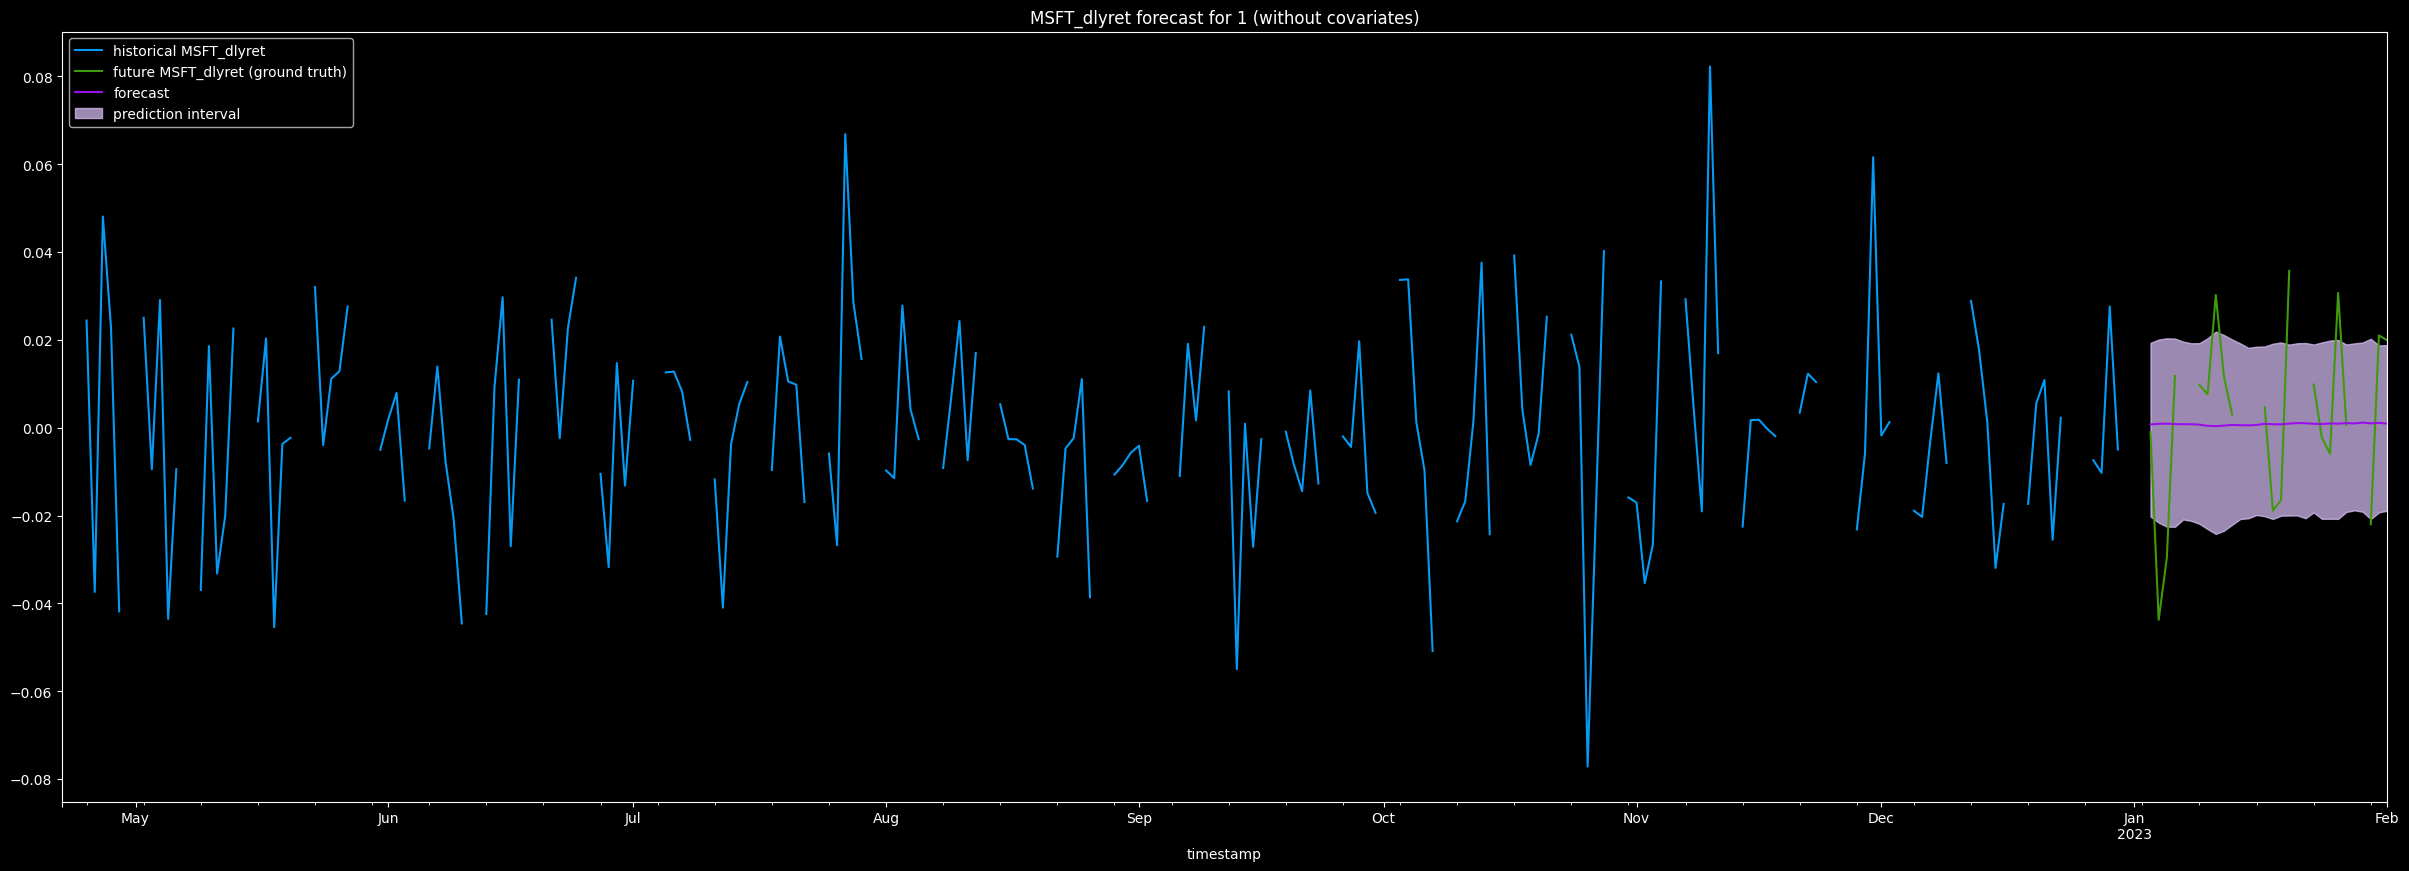

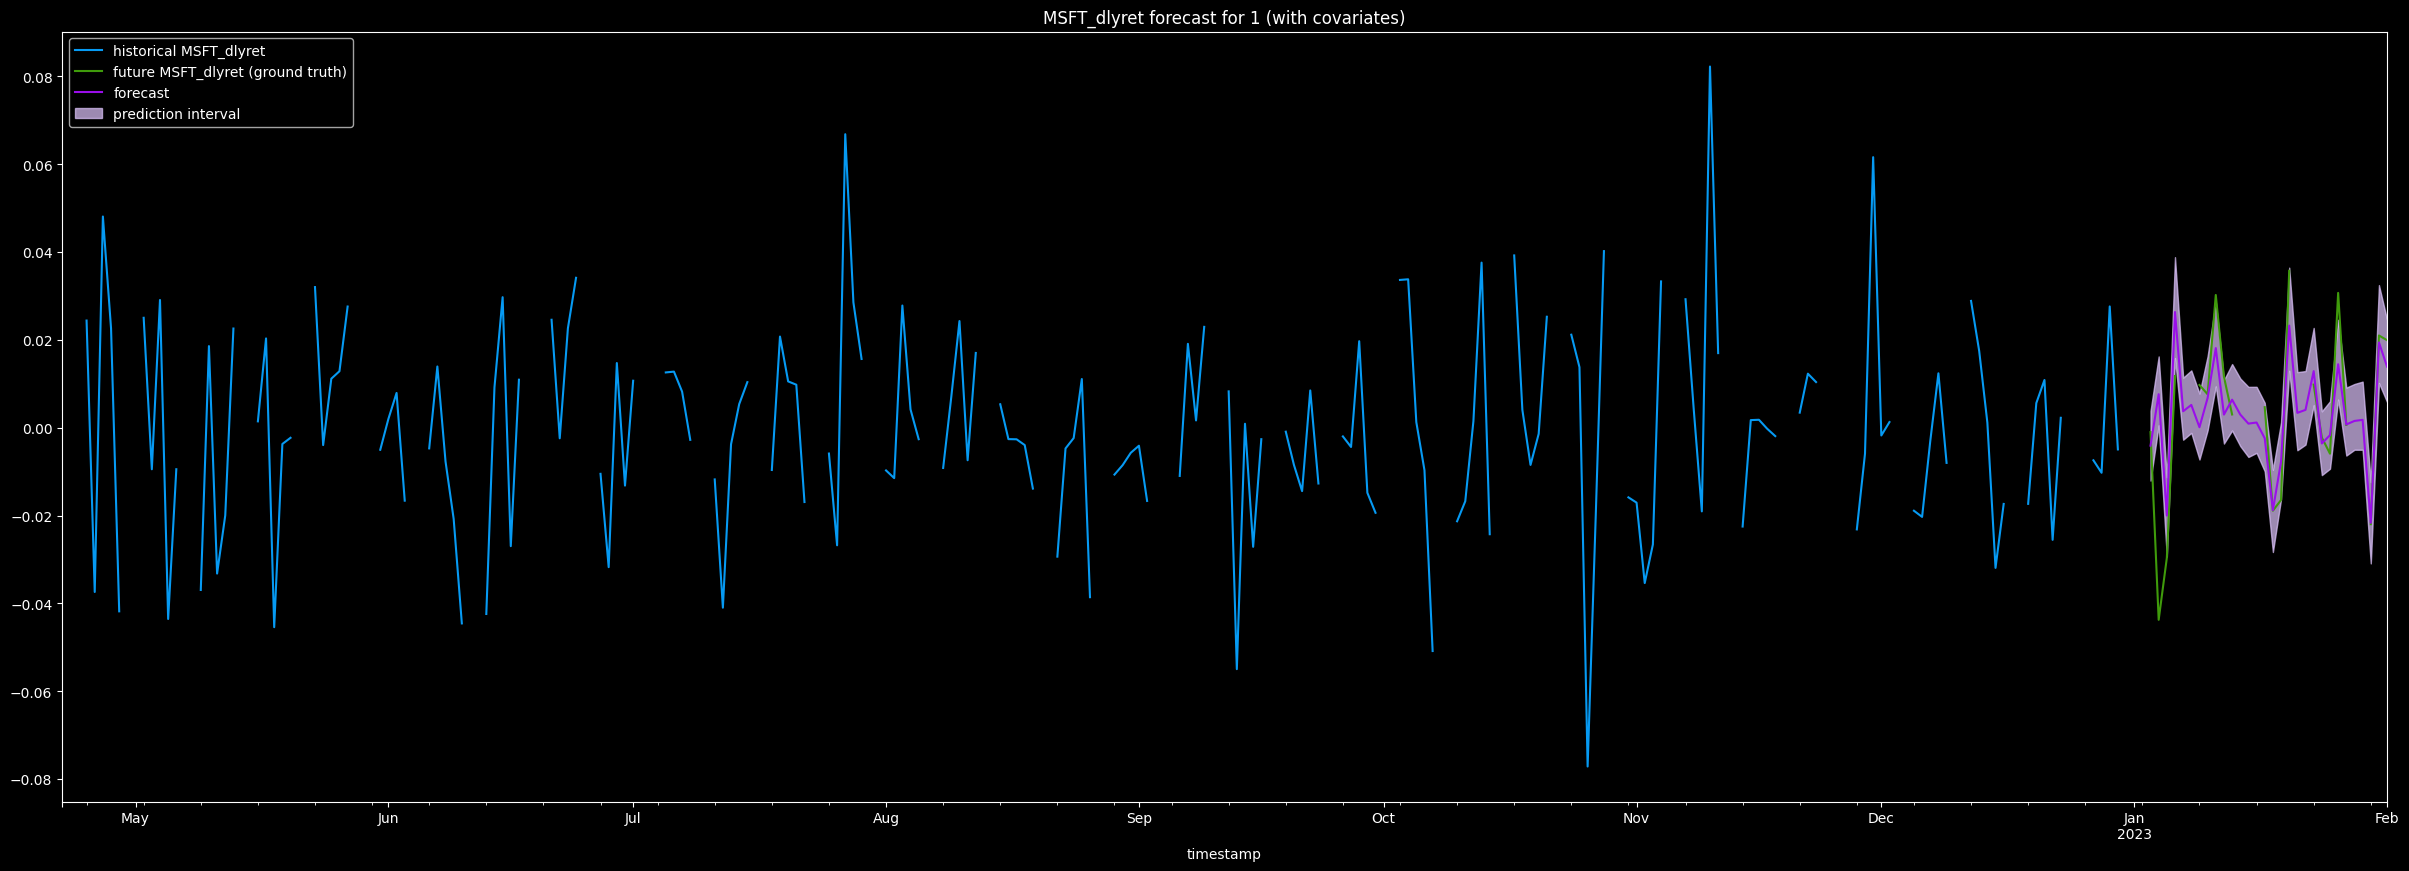

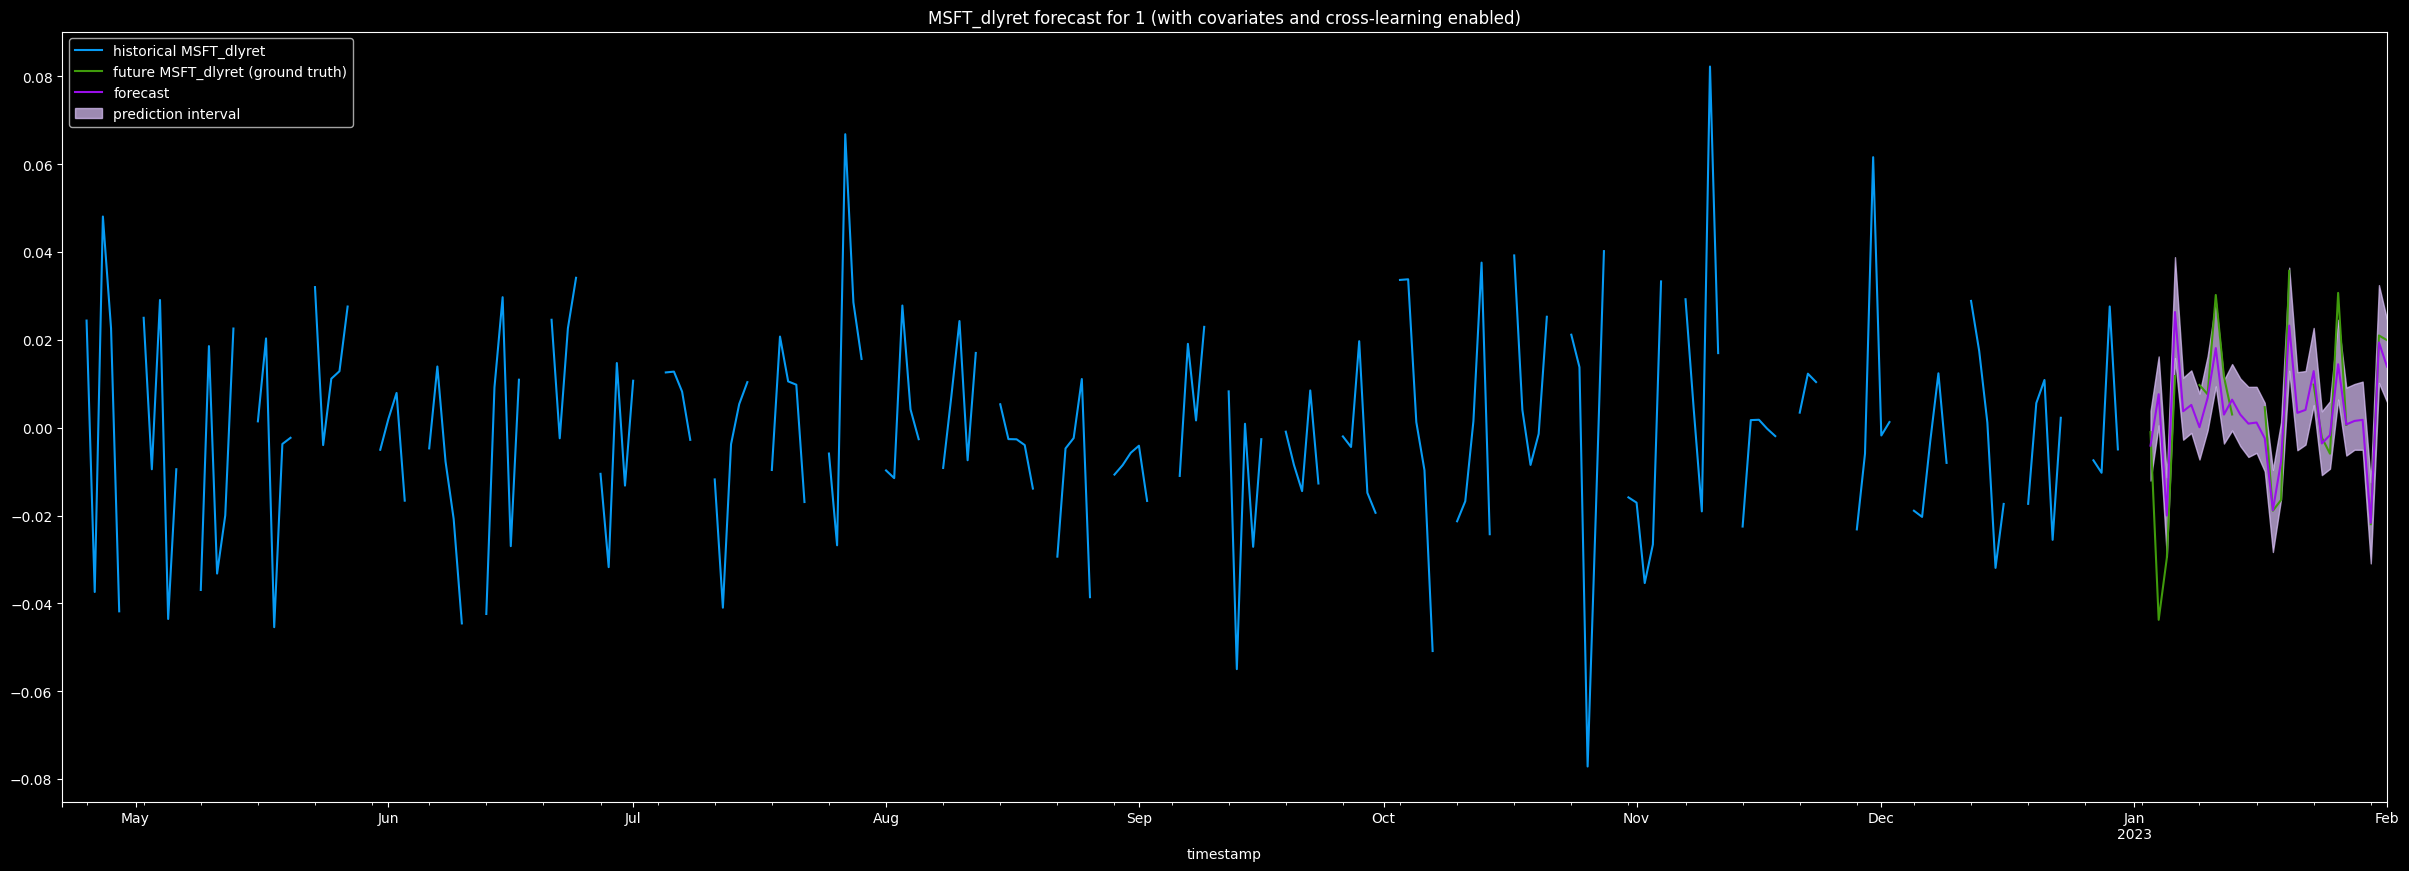

In [16]:
# Visualize forecast with covariates
plot_forecast(
    context_df,
    pred_no_cov_df,
    test_df,
    target_column=target,
    timeseries_id=timeseries_id,
    title_suffix="(without covariates)",
)
plot_forecast(
    context_df,
    pred_df,
    test_df,
    target_column=target,
    timeseries_id=timeseries_id,
    title_suffix="(with covariates)",
)
plot_forecast(
    context_df,
    joint_pred_df,
    test_df,
    target_column=target,
    timeseries_id=timeseries_id,
    title_suffix="(with covariates and cross-learning enabled)",
)